# System setup

In [1]:
import numpy as np, pandas as pd, scipy as sp
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Importing the polling data

In [2]:
import ec_votes as ec, polling_data as poll

# How should we handle polling data

We had a nice discussion in class about the fact that the polls will typically say things like

```python
'Arizona': [['PPP (D): 11/2 - 11/3',46,53,3],
```

which has two issues

1. 46 + 53 != 100
2. 3 is the "margin of error" rather than the std dev.

So, we'll "scale" the results so that we treat it as a 53-46 = 7 point "edge" with a 3/2 = 1.5 std dev. For now, let's just take the most recent polls.

We also have the electoral college votes in a dictionary like

```python
Electoral_College = {'Alabama': ['AL',9],
                    'Alaska': ['AK',3],
```

In [3]:
STATE_NAMES = np.array(list(poll.States.keys()))
EC_VOTES = np.array([ec.Electoral_College[state][1] for state in STATE_NAMES])

def get_drm_probs():
    """
    return voting results per state, where anything over 0.5 means the democrat wins.
    """
    result = []
    for state in STATE_NAMES:
        description, dempct, reppct, moe = poll.States[state][0] # most recent
        edge = (50 + (dempct - reppct)/2)/100
        result.append(np.random.normal(edge,(moe/2)/100))
    return np.array(result)

def nation_vote_once():
    votes = get_drm_probs()
    d_ec = EC_VOTES[votes > 0.5]
    r_ec = EC_VOTES[votes < 0.5]
    # for more sophisticated analysis, we may want to know the actual breakdown.
    # for general results, just d_ec.sum() is what we need.
    return d_ec.sum(),d_ec,r_ec

In [4]:
def nation_vote_slowly(trials):
    results = [nation_vote_once()[0] for i in range(trials)]
    return np.array(results)

In [5]:
def plot(ec_results,nbins=100):
    dem_win_pct = 100*(ec_results >= 270).sum()/len(ec_results)
    n, bins, patches = plt.hist(ec_results,bins=nbins)
    plt.title('Dem win {d:.1f}%'.format(d=dem_win_pct))    

    # Everything below this just does the coloring.
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    colors = []
    for c in bin_centers:
        if c < 270: 
            colors.append('red')
        else: 
            colors.append('blue')
    for c, p in zip(colors, patches):
        plt.setp(p, 'facecolor', c)



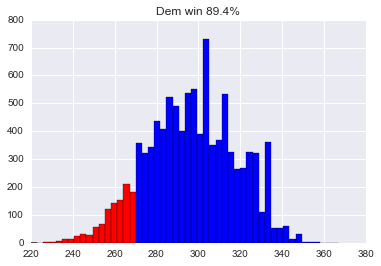

In [21]:
trials = 10000
plot(nation_vote_slowly(trials),nbins=50)

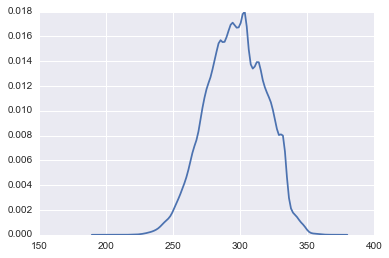

In [7]:
sns.kdeplot(nation_vote_slowly(trials=100000))

## Voting more quickly

I think the above is actually pretty fast, but we can speed it up a bit by asking `np.random.normal` to give us `trials` worth of answers each time.

In [8]:
def get_drm_probs_fast(trials=1):
    """
    return voting results per state, where anything over 0.5 means the democrat wins.
    """
    result = []
    for state in STATE_NAMES:
        description, dempct, reppct, moe = poll.States[state][0] # most recent
        edge = (50 + (dempct - reppct)/2)/100
        result.append(np.random.normal(edge,(moe/2)/100,trials))
    return np.array(result)

In [9]:
get_drm_probs_fast(10).shape

(56, 10)

In [10]:
get_drm_probs_fast(10).mean()

0.49466490185330658

In [11]:
get_drm_probs_fast(10).mean(axis=1).shape

(56,)

In [12]:
def nation_vote_quickly(trials):
    votes = get_drm_probs_fast(trials)
    d_win = votes > 0.5
    # has shape [ec_districts, trials]
    d_ec = d_win * EC_VOTES.reshape((56,1))
    return d_ec.sum(axis=0)

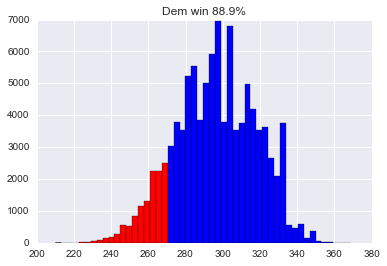

In [13]:
plot(nation_vote_quickly(trials=100000),nbins=50)

In [14]:
%timeit nation_vote_quickly(1000)

100 loops, best of 3: 2.18 ms per loop


In [15]:
%timeit nation_vote_slowly(1000)

10 loops, best of 3: 81.1 ms per loop


## Taking the last several polls into account

One simple improvement would be to take an average of the last N polls. Let's do that in `get_drm_probs_fast`

In [16]:
def get_drm_probs_fast_with_history(trials=1,npolls=1):
    """
    return voting results per state, where anything over 0.5 means the democrat wins.
    """
    result = []
    for state in STATE_NAMES:
        recent_polls = list(reversed(poll.States[state]))[-npolls:]
        edges = [((dempct - reppct),moe) for (description, dempct, reppct, moe) in recent_polls]
        # To be correct for the MOEs here, we should take a weighted average. But we don't know the sample sizes.
        # And smart people would probably weight by pollster reliability. We'll just take the sqrt of the 
        # average of the squares.
        av_edge = np.mean([e for (e,m) in edges]) # could use zip, of course
        stds = np.array([m for (e,m) in edges])/2 # remember, MOE is 2*std
        av_std = np.sqrt((stds**2).mean())
        
        av_edge = (50 + av_edge/2)/100
        av_std = av_std/100
        result.append(np.random.normal(av_edge,av_std,trials))
    return np.array(result)

def nation_vote_quickly_with_history(trials,npolls):
    votes = get_drm_probs_fast_with_history(trials,npolls)
    d_win = votes > 0.5
    # has shape [ec_districts, trials]
    d_ec = d_win * EC_VOTES.reshape((56,1))
    return d_ec.sum(axis=0)

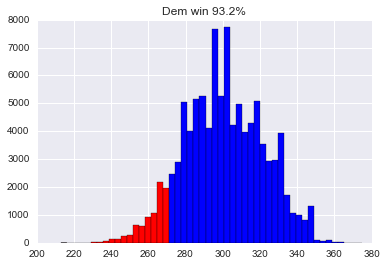

In [17]:
plot(nation_vote_quickly_with_history(trials=100000,npolls=5),nbins=50)

## Array broadcasting

Worth looking up. Here's an example

In [18]:
a = np.array([[3,4],[5,6],[7,8]])
print(a.shape)
print(a)

(3, 2)
[[3 4]
 [5 6]
 [7 8]]


In [19]:
b = np.array([1,2,3])
b.shape

(3,)

In [20]:
a*b

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

In [ ]:
a*b.reshape((3,1))